In [1]:
import json
import pandas as pd
from pathlib import Path
from pprint import pprint
import datetime
import time
import numpy as np
import matplotlib as plt

import pandas
import researchpy as rp
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp

%matplotlib inline

In [2]:
#path_results = Path('/media/discoD/models/elmo/ner/results_20_epochs_ibm')
#path_results = Path('/media/discoD/models/elmo/ner/results_1_epoch_harem_all_combinations')
path_results = Path('/media/discoD/models/elmo/ner/results')

In [3]:
for folder in path_results.iterdir():
    print(folder)

/media/discoD/models/elmo/ner/results/harem-ft_ELMo
/media/discoD/models/elmo/ner/results/harem-ft_ELMo+CNN
/media/discoD/models/elmo/ner/results/harem-ft_ELMo+CNN+Embeddings
/media/discoD/models/elmo/ner/results/harem-ft_ELMo+Embeddings
/media/discoD/models/elmo/ner/results/harem_ELMo
/media/discoD/models/elmo/ner/results/harem_ELMo+CNN
/media/discoD/models/elmo/ner/results/harem_ELMo+CNN+Embeddings
/media/discoD/models/elmo/ner/results/harem_ELMo+Embeddings


In [4]:
configs = dict()
metrics = dict()
for folder in path_results.iterdir():
    results_model_folder = folder.iterdir()
    for training_folder in results_model_folder:
        #print('Reading files from %s' % training_folder.name)
        has_metrics = False
        for results_file in training_folder.iterdir():
            if results_file.name.endswith('.json'):
                #print('Parsing data from %s' % results_file.name)
                if results_file.name.startswith('config'):
                    configs[training_folder.name] = json.loads(results_file.read_bytes())
                elif results_file.name.startswith('metrics.'):
                    metrics[training_folder.name] = json.loads(results_file.read_bytes())
                    has_metrics = True
        if not has_metrics:
            print('metrics.json not found for %s' % training_folder.name)
            del configs[training_folder.name]
print(len(metrics))
print(len(configs))

metrics.json not found for harem_ELMo+CNN+Embeddings_wang2vec_cbow_8_0
259
259


In [5]:
def get_seconds(time_str):
    x = time.strptime(time_str,'%H:%M:%S')
    return datetime.timedelta(hours=x.tm_hour,minutes=x.tm_min,seconds=x.tm_sec).total_seconds()
def get_average_epoch_duration(metrics):
    seconds = get_seconds(metrics['training_duration'])
    training_epochs = metrics['training_epochs'] + 1
    return seconds / training_epochs

In [6]:
TRAINING_ID = 'Training_ID'
SCENARIO = 'Scenario'
MODEL = 'Model'
REPRESENTATION = 'Representation'
EMBEDDING = 'Embedding'
EMBEDDING_TYPE = 'Embedding_Type'
BATCH_SIZE = 'Batch_Size'
ELMO_DROPOUT = 'ELMo_Dropout'
TRAINING_NUMBER = 'Training_Number'
EXECUTION_NUMBER = 'Execution_Number'
BEST_EPOCH = 'Best_Epoch'
TRAINING_EPOCHS = 'Training_Epochs'
TRAINING_DURATION = 'Training_Duration'
TOTAL_DURATION = 'Total_Duration(s)'
AVERAGE_EPOCH_DURATION = 'Average_Epoch_Duration(s)'
TRAINING_ACCURACY = 'Training_Accuracy'
TRAINING_ACCURACY_TOP3 = 'Training_Accuracy_Top-3'
TRAINING_PRECISION = 'Training_Precision'
TRAINING_RECALL = 'Training_Recall'
TRAINING_F1_MEASURE = 'Training_F1-Measure'
TRAINING_LOSS = 'Training_Loss'
BEST_VALIDATION_ACCURACY = 'Best_Validation_Accuracy'
BEST_VALIDATION_ACCURACY_TOP3 = 'Best_Validation_Accuracy_Top-3'
BEST_VALIDATION_PRECISION = 'Best_Validation_Precision'
BEST_VALIDATION_RECALL = 'Best_Validation_Recall'
BEST_VALIDATION_F1_MEASURE = 'Best_Validation_F1-Measure'
BEST_VALIDATION_LOSS = 'Best_Validation_Loss'
TEST_ACCURACY = 'Test_Accuracy'
TEST_ACCURACY_TOP3 = 'Test_Accuracy_Top-3'
TEST_PRECISION = 'Test_Precision'
TEST_RECALL = 'Test_Recall'
TEST_F1_MEASURE = 'Test_F1_Measure'
TEST_LOSS = 'Test_Loss'
columns = [TRAINING_ID, MODEL, REPRESENTATION, EMBEDDING, EMBEDDING_TYPE, TRAINING_NUMBER, EXECUTION_NUMBER, BEST_EPOCH, TRAINING_EPOCHS, TRAINING_DURATION, TOTAL_DURATION, AVERAGE_EPOCH_DURATION, TRAINING_ACCURACY, TRAINING_ACCURACY_TOP3, TRAINING_PRECISION, TRAINING_RECALL, TRAINING_F1_MEASURE, TRAINING_LOSS, BEST_VALIDATION_ACCURACY, BEST_VALIDATION_ACCURACY_TOP3, BEST_VALIDATION_PRECISION, BEST_VALIDATION_RECALL, BEST_VALIDATION_F1_MEASURE, BEST_VALIDATION_LOSS, TEST_ACCURACY, TEST_ACCURACY_TOP3, TEST_PRECISION, TEST_RECALL, TEST_F1_MEASURE, TEST_LOSS]
columns

['Training_ID',
 'Model',
 'Representation',
 'Embedding',
 'Embedding_Type',
 'Training_Number',
 'Execution_Number',
 'Best_Epoch',
 'Training_Epochs',
 'Training_Duration',
 'Total_Duration(s)',
 'Average_Epoch_Duration(s)',
 'Training_Accuracy',
 'Training_Accuracy_Top-3',
 'Training_Precision',
 'Training_Recall',
 'Training_F1-Measure',
 'Training_Loss',
 'Best_Validation_Accuracy',
 'Best_Validation_Accuracy_Top-3',
 'Best_Validation_Precision',
 'Best_Validation_Recall',
 'Best_Validation_F1-Measure',
 'Best_Validation_Loss',
 'Test_Accuracy',
 'Test_Accuracy_Top-3',
 'Test_Precision',
 'Test_Recall',
 'Test_F1_Measure',
 'Test_Loss']

In [7]:
def get_training_data_from_id(training_id, config):
    data = training_id.split('_')
    print(data)
    if len(data) == 4:
        return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: 'No', EMBEDDING_TYPE: 'No', TRAINING_NUMBER: data[2], EXECUTION_NUMBER: data[3]}
    elif len(data) == 5:
        #GloVe
        return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: data[2], EMBEDDING_TYPE: 'No', TRAINING_NUMBER: data[3], EXECUTION_NUMBER: data[4]}
    elif len(data) == 6:
        return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: data[2], EMBEDDING_TYPE: data[3], TRAINING_NUMBER: data[4], EXECUTION_NUMBER: data[5]}
    else:
        print('Check id: %s' % training_id)

In [8]:
training_data = []
for training_id, config in configs.items():
    training_metrics = metrics[training_id]
    data = get_training_data_from_id(training_id, config)
    data[TRAINING_ID] = training_id
    data[BEST_EPOCH] = training_metrics['best_epoch'] if training_metrics else None
    data[TRAINING_EPOCHS] = training_metrics['training_epochs'] + 1 if training_metrics else None
    data[TRAINING_DURATION] = training_metrics['training_duration'] if training_metrics else None
    data[TOTAL_DURATION] = get_seconds(training_metrics['training_duration']) if training_metrics else None
    data[AVERAGE_EPOCH_DURATION] = get_average_epoch_duration(training_metrics) if training_metrics else None
    data[TRAINING_ACCURACY] = training_metrics['training_accuracy'] if training_metrics else None
    data[TRAINING_ACCURACY_TOP3] = training_metrics['training_accuracy3'] if training_metrics else None
    data[TRAINING_PRECISION] = training_metrics['training_precision-overall'] if training_metrics else None
    data[TRAINING_RECALL] = training_metrics['training_recall-overall'] if training_metrics else None
    data[TRAINING_F1_MEASURE] = training_metrics['training_f1-measure-overall'] if training_metrics else None
    data[TRAINING_LOSS] = training_metrics['training_loss'] if training_metrics else None
    data[BEST_VALIDATION_ACCURACY] = training_metrics['best_validation_accuracy'] if training_metrics else None
    data[BEST_VALIDATION_ACCURACY_TOP3] = training_metrics['best_validation_accuracy3'] if training_metrics else None
    data[BEST_VALIDATION_PRECISION] = training_metrics['best_validation_precision-overall'] if training_metrics else None
    data[BEST_VALIDATION_RECALL] = training_metrics['best_validation_recall-overall'] if training_metrics else None
    data[BEST_VALIDATION_F1_MEASURE] = training_metrics['best_validation_f1-measure-overall'] if training_metrics else None
    data[BEST_VALIDATION_LOSS] = training_metrics['best_validation_loss'] if training_metrics else None
    data[TEST_ACCURACY] = training_metrics['test_accuracy'] if training_metrics else None
    data[TEST_ACCURACY_TOP3] = training_metrics['test_accuracy3'] if training_metrics else None
    data[TEST_PRECISION] = training_metrics['test_precision-overall'] if training_metrics else None
    data[TEST_RECALL] = training_metrics['test_recall-overall'] if training_metrics else None
    data[TEST_F1_MEASURE] = training_metrics['test_f1-measure-overall'] if training_metrics else None
    data[TEST_LOSS] = training_metrics['test_loss'] if training_metrics else None
    training_data.append(data)

['harem-ft', 'ELMo', '0', '0']
['harem-ft', 'ELMo', '1', '0']
['harem-ft', 'ELMo', '2', '0']
['harem-ft', 'ELMo', '3', '0']
['harem-ft', 'ELMo', '4', '0']
['harem-ft', 'ELMo', '5', '0']
['harem-ft', 'ELMo', '6', '0']
['harem-ft', 'ELMo', '7', '0']
['harem-ft', 'ELMo+CNN', '0', '0']
['harem-ft', 'ELMo+CNN', '1', '0']
['harem-ft', 'ELMo+CNN', '2', '0']
['harem-ft', 'ELMo+CNN', '3', '0']
['harem-ft', 'ELMo+CNN', '4', '0']
['harem-ft', 'ELMo+CNN', '5', '0']
['harem-ft', 'ELMo+CNN', '6', '0']
['harem-ft', 'ELMo+CNN', '7', '0']
['harem-ft', 'ELMo+CNN+Embeddings', 'fasttext', 'cbow', '0', '0']
['harem-ft', 'ELMo+CNN+Embeddings', 'fasttext', 'cbow', '1', '0']
['harem-ft', 'ELMo+CNN+Embeddings', 'fasttext', 'cbow', '2', '0']
['harem-ft', 'ELMo+CNN+Embeddings', 'fasttext', 'cbow', '3', '0']
['harem-ft', 'ELMo+CNN+Embeddings', 'fasttext', 'cbow', '4', '0']
['harem-ft', 'ELMo+CNN+Embeddings', 'fasttext', 'cbow', '5', '0']
['harem-ft', 'ELMo+CNN+Embeddings', 'fasttext', 'cbow', '6', '0']
['harem-ft

In [9]:
pd.set_option('display.max_columns', 1000)
training_data_df = pd.DataFrame(training_data, columns=columns)
training_data_df = training_data_df[(training_data_df[TRAINING_NUMBER]).astype(int) < 8]
training_data_df 

,Training_ID,Model,Representation,Embedding,Embedding_Type,Training_Number,Execution_Number,Best_Epoch,Training_Epochs,Training_Duration,Total_Duration(s),Average_Epoch_Duration(s),Training_Accuracy,Training_Accuracy_Top-3,Training_Precision,Training_Recall,Training_F1-Measure,Training_Loss,Best_Validation_Accuracy,Best_Validation_Accuracy_Top-3,Best_Validation_Precision,Best_Validation_Recall,Best_Validation_F1-Measure,Best_Validation_Loss,Test_Accuracy,Test_Accuracy_Top-3,Test_Precision,Test_Recall,Test_F1_Measure,Test_Loss
0,harem-ft_ELMo_0_0,harem-ft,ELMo,No,No,0,0,11,20,00:46:22,2782.0,139.10,0.998377,0.998466,0.981112,0.980583,0.980847,3.849414,0.980111,0.982188,0.823232,0.831633,0.827411,62.998245,0.978612,0.980188,0.829522,0.799332,0.814147,77.248705
1,harem-ft_ELMo_1_0,harem-ft,ELMo,No,No,1,0,12,20,00:22:47,1367.0,68.35,0.997897,0.998055,0.978373,0.973635,0.975998,3.954796,0.989643,0.990540,0.879177,0.892950,0.886010,35.350330,0.978402,0.980203,0.823936,0.795326,0.809378,83.973366
2,harem-ft_ELMo_2_0,harem-ft,ELMo,No,No,2,0,13,20,00:19:09,1149.0,57.45,0.998137,0.998262,0.977649,0.976302,0.976975,3.855790,0.984376,0.985047,0.847082,0.893843,0.869835,59.390949,0.978462,0.980068,0.829060,0.809683,0.819257,83.609045
3,harem-ft_ELMo_3_0,harem-ft,ELMo,No,No,3,0,14,20,00:23:53,1433.0,71.65,0.997940,0.998052,0.975603,0.974546,0.975075,4.645464,0.982919,0.984265,0.823529,0.859951,0.841346,54.943508,0.979092,0.980653,0.826309,0.811686,0.818932,83.605297
4,harem-ft_ELMo_4_0,harem-ft,ELMo,No,No,4,0,19,20,00:23:58,1438.0,71.90,0.997613,0.997816,0.974673,0.971762,0.973215,4.479836,0.984349,0.985636,0.870416,0.853717,0.861985,62.107901,0.977951,0.979602,0.814072,0.799666,0.806805,100.175203
5,harem-ft_ELMo_5_0,harem-ft,ELMo,No,No,5,0,13,20,00:22:26,1346.0,67.30,0.998262,0.998432,0.981749,0.978019,0.979880,3.963059,0.983152,0.984370,0.845433,0.869880,0.857482,61.076297,0.978131,0.979902,0.823108,0.806344,0.814640,82.894618
6,harem-ft_ELMo_6_0,harem-ft,ELMo,No,No,6,0,13,20,00:30:54,1854.0,92.70,0.997784,0.997988,0.976106,0.973727,0.974915,4.538179,0.988124,0.988723,0.867299,0.897059,0.881928,43.815717,0.978927,0.980443,0.827135,0.802003,0.814375,79.324988
7,harem-ft_ELMo_7_0,harem-ft,ELMo,No,No,7,0,19,20,00:20:06,1206.0,60.30,0.997951,0.998109,0.977291,0.976499,0.976895,4.271386,0.987645,0.988891,0.875306,0.899497,0.887237,45.661455,0.979227,0.980803,0.827704,0.810017,0.818765,93.037428
8,harem-ft_ELMo+CNN_0_0,harem-ft,ELMo+CNN,No,No,0,0,16,20,00:29:28,1768.0,88.40,0.998086,0.998276,0.977568,0.975458,0.976512,3.587718,0.980767,0.983281,0.831266,0.854592,0.842767,82.332504,0.978867,0.980443,0.820000,0.807679,0.813793,93.089778
9,harem-ft_ELMo+CNN_1_0,harem-ft,ELMo+CNN,No,No,1,0,17,20,00:25:10,1510.0,75.50,0.997874,0.998078,0.977640,0.976325,0.976982,4.509836,0.988150,0.989146,0.882199,0.879896,0.881046,41.372279,0.978702,0.980398,0.827420,0.802003,0.814513,92.398115


In [10]:
training_data_df.to_csv('training_data_20_epochs_mestrado_all_reps.csv', index=None)

In [11]:
str(datetime.timedelta(seconds=training_data_df[TOTAL_DURATION].mean()))

'0:25:36.386719'

In [12]:
default_exported_columns = ['mean', 'min', 'max', 'std']
renamed_columns = ['Contagem', 'F-Score', 'Desvio Padrão', 'Mínimo', '25%', '50%', '75%', 'Máximo']
exported_columns_names = ['F-Score', 'Mínimo', 'Máximo', 'Desvio Padrão']
model_map = {'harem-ft': 'Sim', 'harem': 'Não'}
representation_map = {'ELMo+CNN+Embeddings': 'ELMo+CNN+Vetor', 'ELMo+Embeddings': 'ELMo+Vetor'}
embedding_type_map = {'skip': 'Skip-Gram', 'No': 'Sem Vetor', 'cbow': 'CBoW'}
embedding_map = {'wang2vec': 'Wang2Vec', 'glove': 'GloVe', 'word2vec': 'Word2Vec', 'No': 'Sem Vetor', 'fasttext': 'FastText'}
replacements_map = {**model_map, **representation_map, **embedding_type_map, **embedding_map}

def get_group_csv(index_names, group_name, group_columns, target_value, index_map, dataframe=training_data_df, exported_columns=default_exported_columns):
    if type(index_names) == str:
        index_names = [index_names]
    group = dataframe.groupby(group_columns).describe()[target_value].sort_values(by='mean', ascending=False)
    for column in exported_columns:
        group[column] = group[column] * 100
    group.index.names = index_names
    group = group.rename(index=index_map)
    group.columns = renamed_columns
    group.to_csv('grupo_' + group_name + '_20_epochs_mestrado_all_reps.csv', columns=exported_columns_names, float_format = '%.2f%%')
    return group

In [13]:
get_group_csv('Ajuste Fino', MODEL, MODEL, TEST_F1_MEASURE, model_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Ajuste Fino,,,,,,,,
Sim,128.0,81.350238,0.516297,79.451127,0.810548,0.814211,0.816634,82.352941
Não,128.0,81.189102,0.585172,79.414298,0.807622,0.812511,0.815944,82.576917


In [14]:
get_group_csv('Representação', REPRESENTATION, REPRESENTATION, TEST_F1_MEASURE, representation_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Representação,,,,,,,,
ELMo,16.0,81.387701,0.366766,80.680478,0.812449,0.814099,0.816114,81.925676
ELMo+CNN+Vetor,112.0,81.301218,0.539677,79.558011,0.809717,0.813937,0.816724,82.576917
ELMo+Vetor,112.0,81.228783,0.584091,79.451127,0.808575,0.813229,0.816157,82.436070
ELMo+CNN,16.0,81.217004,0.644037,79.414298,0.810441,0.812659,0.815928,82.218102


In [15]:
get_group_csv('Tipo de Vetor', EMBEDDING_TYPE, EMBEDDING_TYPE, TEST_F1_MEASURE, embedding_type_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Tipo de Vetor,,,,,,,,
Sem Vetor,64.0,81.386427,0.542426,79.414298,0.811404,0.814589,0.817007,82.352941
Skip-Gram,96.0,81.363606,0.478798,80.184175,0.810658,0.813681,0.817086,82.436070
CBoW,96.0,81.097895,0.599442,79.451127,0.807602,0.811690,0.815248,82.576917


In [16]:
get_group_csv('Vetor', EMBEDDING, EMBEDDING, TEST_F1_MEASURE, embedding_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Vetor,,,,,,,,
Wang2Vec,64.0,81.490679,0.492770,80.462506,0.811734,0.814834,0.818736,82.576917
GloVe,32.0,81.470501,0.556813,80.154466,0.813679,0.816450,0.817623,82.352941
Sem Vetor,32.0,81.302353,0.522790,79.414298,0.811079,0.813918,0.816094,82.218102
Word2Vec,64.0,81.116526,0.558598,79.836929,0.807309,0.812426,0.814899,82.192249
FastText,64.0,81.085047,0.531996,79.451127,0.808400,0.811519,0.814398,82.055660


In [17]:
get_group_csv(['Ajuste Fino', 'Representação', 'Vetor', 'Tipo de Vetor'], 'Model_Rep_Emb_Emb-Typ', [MODEL, REPRESENTATION, EMBEDDING, EMBEDDING_TYPE], TEST_F1_MEASURE, replacements_map)

Contagem    F-Score  \
Ajuste Fino Representação  Vetor     Tipo de Vetor                        
Não         ELMo+Vetor     Wang2Vec  Skip-Gram           8.0  81.651758   
            ELMo+CNN+Vetor Wang2Vec  Skip-Gram           8.0  81.619402   
Sim         ELMo+Vetor     Wang2Vec  Skip-Gram           8.0  81.602324   
            ELMo+CNN+Vetor Wang2Vec  CBoW                8.0  81.583739   
                           GloVe     Sem Vetor           8.0  81.578179   
            ELMo+Vetor     Wang2Vec  CBoW                8.0  81.566447   
                           GloVe     Sem Vetor           8.0  81.534591   
            ELMo+CNN+Vetor Wang2Vec  Skip-Gram           8.0  81.518987   
Não         ELMo+CNN+Vetor GloVe     Sem Vetor           8.0  81.473257   
Sim         ELMo           Sem Vetor Sem Vetor           8.0  81.453739   
            ELMo+CNN       Sem Vetor Sem Vetor           8.0  81.420723   
            ELMo+Vetor     Word2Vec  Skip-Gram           8.0  81.415247   
            ELMo+CNN+Vetor FastText  Skip-Gram           8.0  81.383238   
Não         ELMo           Sem Vetor Sem Vetor           8.0  81.321663   
Sim         ELMo+CNN+Vetor FastText  CBoW                8.0  81.318763   
Não         ELMo+Vetor     GloVe     Sem Vetor           8.0  81.295978   
            ELMo+CNN+Vetor FastText  Skip-Gram           8.0  81.288831   
Sim         ELMo+Vetor     FastText  Skip-Gram           8.0  81.280540   
Não         ELMo+CNN+Vetor Wang2Vec  CBoW                8.0  81.244690   
Sim         ELMo+CNN+Vetor Word2Vec  Skip-Gram           8.0  81.191751   
Não         ELMo+Vetor     Word2Vec  Skip-Gram           8.0  81.185172   
            ELMo+CNN+Vetor Word2Vec  Skip-Gram           8.0  81.152367   
                                     CBoW                8.0  81.152287   
            ELMo+Vetor     Wang2Vec  CBoW                8.0  81.138082   
                           FastText  Skip-Gram           8.0  81.073650   
Sim         ELMo+CNN+Vetor Word2Vec  CBoW                8.0  81.062259   
Não         ELMo+CNN       Sem Vetor Sem Vetor           8.0  81.013286   
Sim         ELMo+Vetor     Word2Vec  CBoW                8.0  80.886866   
Não         ELMo+Vetor     Word2Vec  CBoW                8.0  80.886260   
                           FastText  CBoW                8.0  80.879643   
Sim         ELMo+Vetor     FastText  CBoW                8.0  80.806410   
Não         ELMo+CNN+Vetor FastText  CBoW                8.0  80.649298   

                                                    Desvio Padrão     Mínimo  \
Ajuste Fino Representação  Vetor     Tipo de Vetor                             
Não         ELMo+Vetor     Wang2Vec  Skip-Gram           0.555583  80.711768   
            ELMo+CNN+Vetor Wang2Vec  Skip-Gram           0.495081  80.744310   
Sim         ELMo+Vetor     Wang2Vec  Skip-Gram           0.371607  81.039755   
            ELMo+CNN+Vetor Wang2Vec  CBoW                0.595031  80.462506   
                           GloVe     Sem Vetor           0.473083  80.865829   
            ELMo+Vetor     Wang2Vec  CBoW                0.305867  81.223304   
                           GloVe     Sem Vetor           0.604964  80.154466   
            ELMo+CNN+Vetor Wang2Vec  Skip-Gram           0.456865  80.767272   
Não         ELMo+CNN+Vetor GloVe     Sem Vetor           0.532716  80.208860   
Sim         ELMo           Sem Vetor Sem Vetor           0.456784  80.680478   
            ELMo+CNN       Sem Vetor Sem Vetor           0.361353  80.799334   
            ELMo+Vetor     Word2Vec  Skip-Gram           0.513361  80.656070   
            ELMo+CNN+Vetor FastText  Skip-Gram           0.331139  80.843766   
Não         ELMo           Sem Vetor Sem Vetor           0.263878  80.842322   
Sim         ELMo+CNN+Vetor FastText  CBoW                0.480306  80.343898   
Não         ELMo+Vetor     GloVe     Sem Vetor           0.668355  80.325960   
            ELMo+CNN+Vetor FastText  Skip-Gram           0.28

In [18]:
training_data_df.groupby([EMBEDDING, EMBEDDING_TYPE]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

count      mean       std       min       25%  \
Embedding Embedding_Type                                                  
wang2vec  skip             32.0  0.815981  0.004537  0.807118  0.813314   
glove     No               32.0  0.814705  0.005568  0.801545  0.813679   
wang2vec  cbow             32.0  0.813832  0.005136  0.804625  0.810891   
No        No               32.0  0.813024  0.005228  0.794143  0.811079   
fasttext  skip             32.0  0.812566  0.003642  0.806262  0.810304   
word2vec  skip             32.0  0.812361  0.005279  0.801842  0.809698   
          cbow             32.0  0.809969  0.005709  0.798369  0.806773   
fasttext  cbow             32.0  0.809135  0.006179  0.794511  0.807097   

                               50%       75%       max  
Embedding Embedding_Type                                
wang2vec  skip            0.816067  0.819675  0.824361  
glove     No              0.816450  0.817623  0.823529  
wang2vec  cbow            0.813756  0.817401  0.825769  
No        No              0.813918  0.816094  0.822181  
fasttext  skip            0.812341  0.814655  0.820557  
word2vec  skip            0.812891  0.816001  0.821922  
          cbow            0.810729  0.814515  0.818628  
fasttext  cbow            0.809484  0.813850  0.818487

In [19]:
training_data_skip_df = training_data_df[training_data_df[EMBEDDING_TYPE] != 'cbow']
training_data_skip_df.groupby([EMBEDDING]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Embedding,,,,,,,,
wang2vec,32.0,0.815981,0.004537,0.807118,0.813314,0.816067,0.819675,0.824361
glove,32.0,0.814705,0.005568,0.801545,0.813679,0.816450,0.817623,0.823529
No,32.0,0.813024,0.005228,0.794143,0.811079,0.813918,0.816094,0.822181
fasttext,32.0,0.812566,0.003642,0.806262,0.810304,0.812341,0.814655,0.820557
word2vec,32.0,0.812361,0.005279,0.801842,0.809698,0.812891,0.816001,0.821922


In [20]:
training_data_cbow_df = training_data_df[training_data_df[EMBEDDING_TYPE] != 'skip']
training_data_cbow_df.groupby([EMBEDDING]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Embedding,,,,,,,,
glove,32.0,0.814705,0.005568,0.801545,0.813679,0.816450,0.817623,0.823529
wang2vec,32.0,0.813832,0.005136,0.804625,0.810891,0.813756,0.817401,0.825769
No,32.0,0.813024,0.005228,0.794143,0.811079,0.813918,0.816094,0.822181
word2vec,32.0,0.809969,0.005709,0.798369,0.806773,0.810729,0.814515,0.818628
fasttext,32.0,0.809135,0.006179,0.794511,0.807097,0.809484,0.813850,0.818487


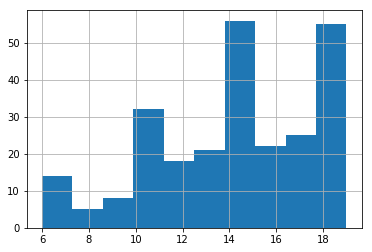

In [21]:
training_data_df[BEST_EPOCH].hist()

In [22]:
training_data_df[TOTAL_DURATION].describe()

count     256.000000
mean     1536.386719
std       335.665314
min      1141.000000
25%      1357.000000
50%      1456.000000
75%      1590.000000
max      2969.000000
Name: Total_Duration(s), dtype: float64

In [23]:
training_data_df.groupby([TRAINING_NUMBER]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Training_Number,,,,,,,,
5,32.0,0.814294,0.006043,0.795580,0.811919,0.814485,0.817744,0.825769
3,32.0,0.814209,0.004650,0.804090,0.810868,0.815252,0.817438,0.821922
2,32.0,0.813305,0.004511,0.798772,0.812415,0.814132,0.816253,0.820784
1,32.0,0.812821,0.004578,0.802089,0.809233,0.813831,0.816024,0.822298
6,32.0,0.812524,0.004677,0.801632,0.808429,0.813124,0.815954,0.822218
7,32.0,0.811906,0.006291,0.799868,0.807635,0.811858,0.817326,0.823529
0,32.0,0.811657,0.006060,0.794143,0.808350,0.812452,0.814475,0.824361
4,32.0,0.810858,0.006823,0.794511,0.806496,0.812518,0.816278,0.822815


In [24]:
rp.summary_cont(training_data_df[TEST_F1_MEASURE])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Test_F1_Measure,256.0,0.812697,0.005566,0.000348,0.812012,0.813382


In [25]:
rp.summary_cont(training_data_df.groupby(EMBEDDING))[TEST_F1_MEASURE]

,N,Mean,SD,SE,95% Conf.,Interval
Embedding,,,,,,
No,32,0.813024,0.005228,0.000924,0.811212,0.814835
fasttext,64,0.810850,0.005320,0.000665,0.809547,0.812154
glove,32,0.814705,0.005568,0.000984,0.812776,0.816634
wang2vec,64,0.814907,0.004928,0.000616,0.813699,0.816114
word2vec,64,0.811165,0.005586,0.000698,0.809797,0.812534


In [26]:
# Calculating effect size
def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])
    
    cols = ['sum_sq', 'mean_sq', 'df', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

def print_anova(parameter):
    # Fits the model with the interaction term
    # This will also automatically include the main effects for each factor
    model = ols('Test_F1_Measure ~ C({0})'.format(parameter), training_data_df).fit()
    # Seeing if the overall model is significant
    print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .20f}")
    print(model.summary())
    res = sm.stats.anova_lm(model, typ= 2)
    print(res)
    print(anova_table(res))
    mc = statsmodels.stats.multicomp.MultiComparison(training_data_df[TEST_F1_MEASURE], training_data_df[parameter])
    mc_results = mc.tukeyhsd()
    print(mc_results)

In [27]:
print_anova(EMBEDDING)

Overall model F( 4, 251) =  7.202, p =  0.00001667767788907732
                            OLS Regression Results                            
Dep. Variable:        Test_F1_Measure   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     7.202
Date:                Sun, 02 Jun 2019   Prob (F-statistic):           1.67e-05
Time:                        10:49:37   Log-Likelihood:                 980.07
No. Observations:                 256   AIC:                            -1950.
Df Residuals:                     251   BIC:                            -1932.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

In [28]:
training_data_df[(training_data_df.Embedding == 'wang2vec') & (training_data_df.Embedding_Type == 'skip') & (training_data_df.Representation == 'ELMo+Embeddings')]

,Training_ID,Model,Representation,Embedding,Embedding_Type,Training_Number,Execution_Number,Best_Epoch,Training_Epochs,Training_Duration,Total_Duration(s),Average_Epoch_Duration(s),Training_Accuracy,Training_Accuracy_Top-3,Training_Precision,Training_Recall,Training_F1-Measure,Training_Loss,Best_Validation_Accuracy,Best_Validation_Accuracy_Top-3,Best_Validation_Precision,Best_Validation_Recall,Best_Validation_F1-Measure,Best_Validation_Loss,Test_Accuracy,Test_Accuracy_Top-3,Test_Precision,Test_Recall,Test_F1_Measure,Test_Loss
103,harem-ft_ELMo+Embeddings_wang2vec_skip_0_0,harem-ft,ELMo+Embeddings,wang2vec,skip,0,0,11,20,00:29:56,1796.0,89.80,0.998433,0.998612,0.983771,0.980852,0.982309,2.933687,0.980221,0.982297,0.826733,0.852041,0.839196,64.771994,0.978206,0.979932,0.827909,0.798331,0.812851,80.755276
104,harem-ft_ELMo+Embeddings_wang2vec_skip_1_0,harem-ft,ELMo+Embeddings,wang2vec,skip,1,0,15,20,00:23:12,1392.0,69.60,0.998654,0.998722,0.983338,0.984396,0.983867,2.830908,0.988349,0.989345,0.882653,0.903394,0.892903,44.590681,0.979002,0.980758,0.823946,0.815693,0.819799,89.367576
105,harem-ft_ELMo+Embeddings_wang2vec_skip_2_0,harem-ft,ELMo+Embeddings,wang2vec,skip,2,0,17,20,00:19:31,1171.0,58.55,0.998467,0.998569,0.981236,0.979884,0.980560,3.197974,0.984856,0.985910,0.855397,0.891720,0.873181,66.529154,0.978432,0.980203,0.837913,0.804341,0.820784,103.374336
106,harem-ft_ELMo+Embeddings_wang2vec_skip_3_0,harem-ft,ELMo+Embeddings,wang2vec,skip,3,0,10,20,00:23:26,1406.0,70.30,0.998638,0.998761,0.984783,0.981316,0.983046,2.675114,0.982609,0.983747,0.834123,0.864865,0.849216,57.177565,0.979107,0.980623,0.826625,0.802337,0.814300,77.436336
107,harem-ft_ELMo+Embeddings_wang2vec_skip_4_0,harem-ft,ELMo+Embeddings,wang2vec,skip,4,0,13,20,00:23:48,1428.0,71.40,0.998540,0.998642,0.983184,0.984252,0.983718,3.310123,0.984151,0.985042,0.870416,0.853717,0.861985,55.164751,0.978882,0.980353,0.825322,0.814023,0.819634,83.847991
108,harem-ft_ELMo+Embeddings_wang2vec_skip_5_0,harem-ft,ELMo+Embeddings,wang2vec,skip,5,0,18,20,00:22:33,1353.0,67.65,0.998793,0.998838,0.984807,0.985075,0.984941,2.737665,0.984370,0.985588,0.853774,0.872289,0.862932,69.016578,0.979272,0.980983,0.829024,0.803005,0.815807,103.212363
109,harem-ft_ELMo+Embeddings_wang2vec_skip_6_0,harem-ft,ELMo+Embeddings,wang2vec,skip,6,0,19,20,00:29:57,1797.0,89.85,0.998462,0.998553,0.981306,0.981040,0.981173,2.895771,0.988423,0.989321,0.879808,0.897059,0.888350,49.870601,0.978777,0.980443,0.825506,0.804007,0.814614,100.993161
110,harem-ft_ELMo+Embeddings_wang2vec_skip_7_0,harem-ft,ELMo+Embeddings,wang2vec,skip,7,0,16,20,00:23:04,1384.0,69.20,0.998841,0.998942,0.984337,0.984603,0.984470,2.475870,0.988268,0.989618,0.889724,0.891960,0.890841,47.286311,0.977801,0.979647,0.824974,0.796327,0.810398,98.049989
234,harem_ELMo+Embeddings_wang2vec_skip_0_0,harem,ELMo+Embeddings,wang2vec,skip,0,0,13,20,00:22:13,1333.0,66.65,0.998925,0.999004,0.986242,0.985976,0.986109,2.541221,0.980330,0.982625,0.818859,0.841837,0.830189,77.700663,0.979137,0.980893,0.830790,0.818030,0.824361,84.732031
235,harem_ELMo+Embeddings_wang2vec_skip_1_0,harem,ELMo+Embeddings,wang2vec,skip,1,0,18,20,00:29:27,1767.0,88.35,0.998892,0.998948,0.987864,0.985472,0.986667,2.464469,0.989942,0.991038,0.884319,0.898172,0.891192,44.987702,0.978086,0.979962,0.817479,0.812020,0.814740,104.140458
